# Scenario D - Peakshape Variation

In this scenario the peakshape in a spectrum with a fixed number of peaks is varied from Gaussian (n = 0.0) to Lorentzian (n = 1.0). All datasets contain 3 peaks and the noise level is kept constant at 1%.

The model used in the inference of the parameters is formulated as follows:

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot f_{pseudo-Voigt}(x)\big] + \epsilon
\end{equation}

where:

\begin{equation}
\large f_{pseudo-Voigt}(x) = \eta \cdot \frac{\sigma_m^2}{(x-\mu_m)^2 + \sigma_m^2} + (1 - \eta) \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local modules

In [2]:
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf

## Local configuration

In [3]:
# output for results and images
out_path      = './output_peakshape_plot'
file_basename = out_path + '/scenario_peakshape'
        
conf = {}
    
# scenario name
conf['scenario'] = 'peakshape variation'
    
# initialization method for sampler
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors)
conf['prior_model'] = 'lognormal'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# model mode ('train'/eval')
conf['model_mode'] = 'train'

# data mode ('generate'/'preload')
conf['data_mode'] = 'generate'

# dataset directory (needed for 'preload' data mode)
#conf['dataset_dir'] = './input_datasets'

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [4]:
# if the output dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf

{'scenario': 'peakshape variation',
 'init_mode': 'adapt_diag',
 'prior_model': 'lognormal',
 'peak_info': 'yes',
 'model_mode': 'train',
 'data_mode': 'generate',
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [5]:
cnf.save(out_path, conf)

# Generate data and plot

In [6]:
# list of wavelengths (x-values)
xval = [i for i in range(200, 400, 2)]

ldata  = []
lpeaks = []
lpeakshape = []

# number of spectra per baseline variation
nsets  = 1

# peakshape weight factors (0 = Gauss, 1 = Lorentz)
#peakshapes = [0.0, 0.25, 0.5, 0.75, 1.0]
peakshapes = [0.0, 1.0]
lpeakshape = [ps for ps in peakshapes for i in range(nsets)]

# total number of datasets
tsets = nsets * len(peakshapes)
        
if conf['model_mode'] == 'train' and conf['data_mode'] == 'generate':
    # generate the datasets
    for ps in peakshapes:
        for i in range(nsets):
            df, peaks, _ = dg.data_generator(xvalues=xval, nsamples=15, npeaks=3, peakshape=ps)
            ldata.append(df)
            lpeaks.append(peaks)
            
    # save data and peak information to disk
    for i in range(len(ldata)):
        ldata[i].to_csv(out_path + '/dataset_%02d.csv' % (i+1), index=False)
    dg.data_save(out_path + '/peakinfo.csv', lpeaks)
        
elif conf['model_mode'] == 'train' and conf['data_mode'] == 'preload':           
    # load pre-generated datasets from disk
    ldata, lpeaks, _ = dg.data_load(tsets, conf['dataset_dir'])
    
else:        
    # load data from disk
    if conf['data_mode'] == 'preload':
        ldata, lpeaks, _ = dg.data_load(tsets, conf['dataset_dir'])
    else:
        ldata, lpeaks, _ = dg.data_load(tsets, out_path)

In [7]:
print("total number of peakshape variations    : {0}".format(len(peakshapes)))
print("total number of datasets per peakshape  : {0}".format(nsets))
print("total number of datasets per model      : {0}".format(tsets))
print("total number of inference runs          : {0}".format(nsets*len(peakshapes)**2))

total number of peakshape variations    : 2
total number of datasets per peakshape  : 1
total number of datasets per model      : 2
total number of inference runs          : 4


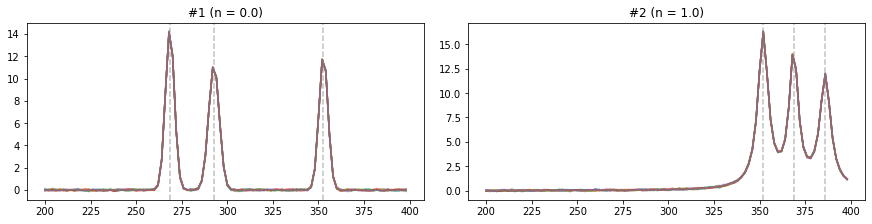

In [9]:
# plot datasets
fig.plot_datasets(ldata, lpeaks, dims=(int(tsets/2),2), figure_size=(12,int(tsets*(1.8))), 
                            savefig='yes', fname=file_basename, scenario='peakshape', labels=lpeakshape)

# Initialize models and run inference

In [10]:
# convert pandas data to numpy arrays
x_val = np.array(xval, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [11]:
# initialize models and run inference
models = []
traces = []

# list of tuples with (model peakshape, data peakshape) combination
lmodbase = []

# actual run number
run = 1

# total number of inference runs
truns = nsets * len(peakshapes)**2

for ps in peakshapes:
    if conf['model_mode'] == 'train':
        # for each baseline model run inference on all spectra
        print("running: n = {0} peakshape model".format(ps))
    
    for i in range(len(ldata)):
        if conf['peak_info'] == 'yes':
            plist = lpeaks[i].flatten()
            plist.sort()
            model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=3, peakshape=ps,
                                  mu_peaks=plist, pmodel=conf['prior_model'])
        else:
            model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=3, peakshape=ps,
                                                  pmodel=conf['prior_model'])
                
        models.append(model_g)

        with model_g:
            if conf['model_mode'] == 'train':
                print("({2}/{3}) running inference on dataset #{0}/{1} [{4} model: {5} data]"
                      .format(i+1,len(ldata),run,truns,ps,lpeakshape[i]))
                trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
                lmodbase += [(ps,lpeakshape[i])]
                traces.append(trace_g)
                # save inference results
                pm.backends.text.dump(out_path + '/traces_%02d' % (run), trace_g)
            else:
                # load traces from disk
                print("loading dataset #{0}/{1}".format(run,truns))
                trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (run))
                traces.append(trace_g)
            run += 1

running: n = 0.0 peakshape model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(1/4) running inference on dataset #1/2 [0.0 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 7 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 340.62draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8845128112555963, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8869355857990738, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(2/4) running inference on dataset #2/2 [0.0 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 424.11draws/s]


running: n = 1.0 peakshape model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(3/4) running inference on dataset #1/2 [1.0 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 284.72draws/s]
The acceptance probability does not match the target. It is 0.6956456538664311, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(4/4) running inference on dataset #2/2 [1.0 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 315.79draws/s]
The acceptance probability does not match the target. It is 0.9071400366520144, but should be close to 0.8. Try to increase the number of tuning steps.


# Model visualization

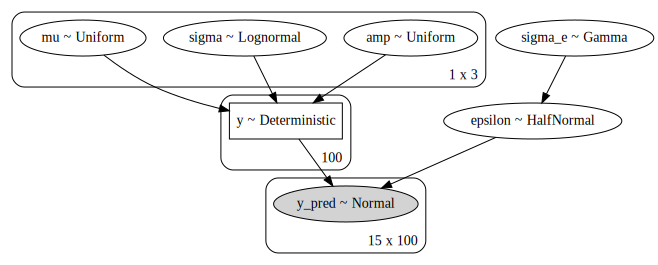

In [12]:
# display first model
pm.model_to_graphviz(models[0])

In [13]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [14]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 431.76it/s]
/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 437.51it/s]


In [15]:
# various plots to inspect the inference results
varnames = mdl.get_varnames(traces[0])

#az.plot_trace(traces[2], varnames, compact=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[0], varnames);
#az.plot_posterior(traces[8], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

#az.summary(traces[20], varnames)

In [16]:
if conf['model_mode'] == 'train':
    # collect the results and display
    df = res.get_results_summary(traces, ppc, y_val, varnames, epsilon_real=0.05, sets=tsets, labels=lmodbase)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
    
    # create list of tuples with model/data combinations
    lm = df['model'].to_list()
    ld = df['data'].to_list()
    lmodbase = list(zip(lm,ld))
df

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,r_hat,mcse,ess,bfmi,r2,waic,epsilon,epsilon_real,model,data
1,1.0,0.000,5470.0,1.047060,0.999672,-4402.954623,0.055570,0.05,0.0,0.0
2,1.0,0.001,4596.4,1.060364,0.974772,2685.370266,0.586127,0.05,0.0,1.0
3,1.0,0.001,3188.9,1.077778,0.956788,2771.847666,0.605841,0.05,1.0,0.0
4,1.0,0.000,3525.2,1.075421,0.999802,-4665.375112,0.050986,0.05,1.0,1.0


In [17]:
if conf['model_mode'] == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

# Plot posterior

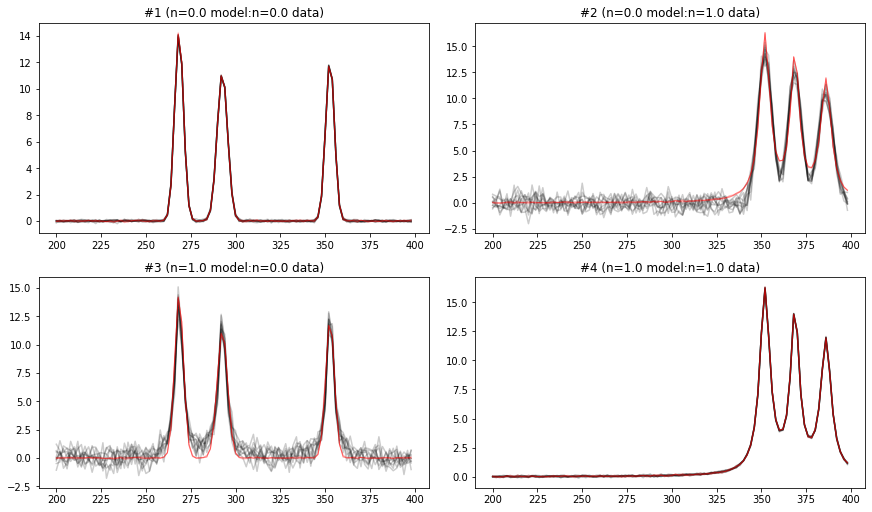

In [18]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(truns/2),2), figure_size=(12,int(truns*(1.8))),
            savefig='yes', fname=file_basename, showpeaks='no', sets=tsets, labels=lmodbase, scenario='peakshape')

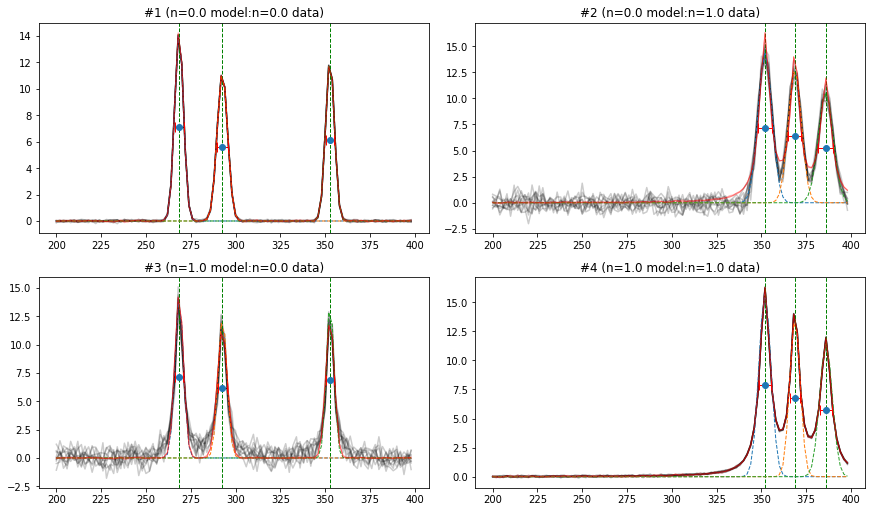

In [19]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(truns/2),2), figure_size=(12,int(truns*(1.8))),
            savefig='yes', fname=file_basename, showpeaks='yes', sets=tsets, labels=lmodbase, scenario='peakshape')

In [20]:
cnf.close(out_path)

# Plot posterior (single dataset)

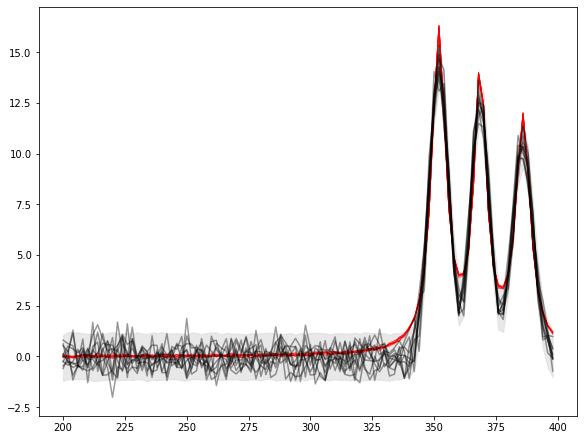

In [28]:
# dataset to plot
n_dataset = 1

# trace number in matrix
n_trace = 1

plt.figure(figsize=(8,6), constrained_layout=True)

# plot datavalues
for i in range(10):
    y_val = ldata[n_dataset].values[i]
    plt.plot(x_val, y_val, '-', color="red", alpha=.5, linewidth=1)

# HPD plot    
az.plot_hpd(x_val, ppc[n_trace]['y_pred'], credible_interval=0.95, smooth=False, color='lightgray');

# plot posterior samples
sp = ppc[n_trace]['y_pred']
for i in range(10):
    plt.plot(x_val, sp[-i, i, :], '-', color="black", alpha=.4)

plt.savefig(file_basename + '_single_ppc.png', dpi=150)